In [18]:
from stardist.models import StarDist3D
import numpy as np
import pandas as pd
import napari
from skimage.segmentation import relabel_sequential
from tifffile import imread
from stardist.matching import matching, matching_dataset, group_matching_labels
from tqdm import tqdm
from skimage.segmentation import relabel_sequential
import statistics

import sys
import os
from pathlib import Path

cwd = os.getcwd()
# print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[3])
# print(f"Module dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data.preprocess_utils import load_files, resample_crop_downsample
from src.models.stardist3D import stardist_predict, threshold_optimization
from src.evaluation.evaluate_models import get_boundary_based_metrics_per_object
from src.visualization.visualize import plot_matching_dataset_results, plot_confusion_matrix
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette("Set2")

In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

## Experiments´ directories

In [63]:
Path(os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw")).mkdir(parents=True, exist_ok=True)   # create dir to save figures
Path(os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_raw", "metrics")).mkdir(parents=True, exist_ok=True)   # create dir to save metrics

In [4]:
exp_dir1 = os.path.join(module_path, "experiments", "exp01")
exp_dir10 = os.path.join(module_path, "experiments", "exp10")
exp_dir11 = os.path.join(module_path, "experiments", "exp11")

## Load predictions

In [11]:
predictions1 = resample_crop_downsample(os.path.join(exp_dir1, "results"), rescale=True, rescale_factor=[1.007, 1.007, 1.007])
predictions1[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp01\results



Preprocessing files: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.76it/s]


(288, 288, 288)

In [22]:
predictions2 = resample_crop_downsample(os.path.join(exp_dir10, "results"), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions2[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp10\results




Preprocessing files:   0%|                                                                      | 0/35 [00:00<?, ?it/s]

Preprocessing files:   3%|█▊                                                            | 1/35 [00:00<00:25,  1.34it/s]

Preprocessing files:   6%|███▌                                                          | 2/35 [00:00<00:13,  2.46it/s]

Preprocessing files:   9%|█████▎                                                        | 3/35 [00:01<00:09,  3.31it/s]

Preprocessing files:  11%|███████                                                       | 4/35 [00:01<00:08,  3.81it/s]

Preprocessing files:  14%|████████▊                                                     | 5/35 [00:01<00:06,  4.29it/s]

Preprocessing files:  17%|██████████▋                                                   | 6/35 [00:01<00:06,  4.68it/s]

Preprocessing files:  20%|████████████▍                                                 | 7/35 [00:01<00:05,  4.78it/s]

Preprocessing files:  23%|████

(288, 288, 288)

In [23]:
predictions3 = resample_crop_downsample(os.path.join(exp_dir11, "results"), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions3[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp11\results




Preprocessing files:   0%|                                                                      | 0/35 [00:00<?, ?it/s]

Preprocessing files:   3%|█▊                                                            | 1/35 [00:00<00:25,  1.34it/s]

Preprocessing files:   6%|███▌                                                          | 2/35 [00:00<00:13,  2.40it/s]

Preprocessing files:   9%|█████▎                                                        | 3/35 [00:01<00:10,  3.09it/s]

Preprocessing files:  11%|███████                                                       | 4/35 [00:01<00:08,  3.74it/s]

Preprocessing files:  14%|████████▊                                                     | 5/35 [00:01<00:07,  4.24it/s]

Preprocessing files:  17%|██████████▋                                                   | 6/35 [00:01<00:06,  4.49it/s]

Preprocessing files:  20%|████████████▍                                                 | 7/35 [00:01<00:05,  4.81it/s]

Preprocessing files:  23%|████

(288, 288, 288)

In [ ]:
raw = load_files(os.path.join(module_path, "data", "stardist_train_val_test_2022-07-28", "test", "raw_normalized"))

## Visualize in napari

In [7]:
viewer = napari.Viewer()

# add original raw data
viewer.add_image(np.array(raw))

# add predicted labels
viewer.add_labels((np.array(predictions1)).astype('int32'), name="exp01_pred")
viewer.add_labels((np.array(predictions2)).astype('int32'), name="exp10_pred")
viewer.add_labels((np.array(predictions3)).astype('int32'), name="exp11_pred")

__init__.py (194): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


<Labels layer 'exp11_pred' at 0x204afd66790>

## Metrics

In [9]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]   # different threshold values for pred to be considered tp

In [7]:
y_true = load_files(os.path.join(module_path, "data", "matched_test_set", "isotropic"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\matched_test_set\isotropic


### Exp01

In [12]:
metrics1 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions1).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:54<00:00, 39.39s/it]


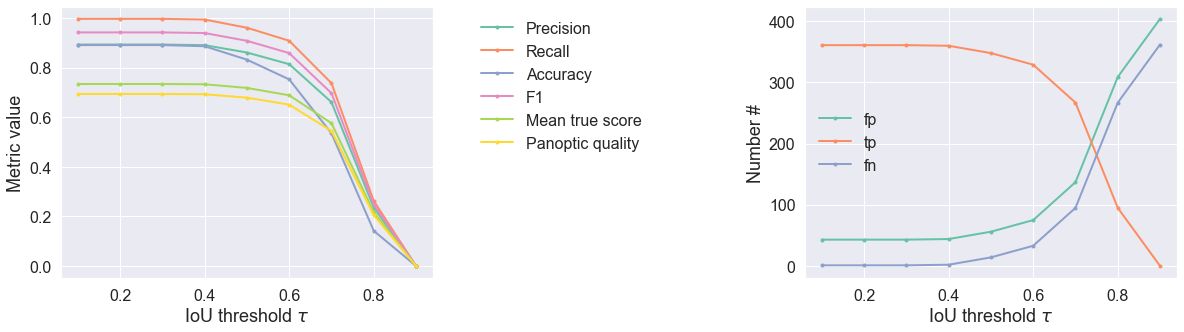

In [25]:
plot_matching_dataset_results(metrics1, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw", "exp01_multithres_plots.png"))

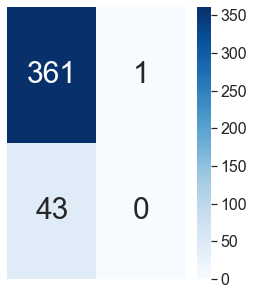

In [26]:
plot_confusion_matrix(metrics1, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw", "exp01_cm.png"))

### Exp10

In [24]:
metrics2 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions2).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|█████████▎                                                                          | 1/9 [00:40<05:22, 40.25s/it]

 22%|██████████████████▋                                                                 | 2/9 [01:23<04:53, 41.90s/it]

 33%|████████████████████████████                                                        | 3/9 [02:05<04:11, 42.00s/it]

 44%|█████████████████████████████████████▎                                              | 4/9 [02:47<03:31, 42.20s/it]

 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:29<02:48, 42.09s/it]

 67%|████████████████████████████████████████████████████████                            | 6/9 [04:06<02:01, 40.35s/it]

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [04:43<01:18, 39.20s/it]

 89%|█████████████████████████

In [27]:
dfs = []
for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"):
    metric={m: metrics2[taus.index(0.3)]._asdict()[m]}
    # print(pd.DataFrame.from_dict(metric, orient='index'))
    dfs.append(pd.DataFrame.from_dict(metric, orient='index'))
    
metrics2df = pd.concat(dfs, axis=0)
metrics2df.T

,tp,fn,fp,precision,recall,accuracy,f1,mean_true_score,mean_matched_score,panoptic_quality
0,362.0,0.0,29.0,0.925831,1.0,0.925831,0.961487,0.791743,0.791743,0.761251


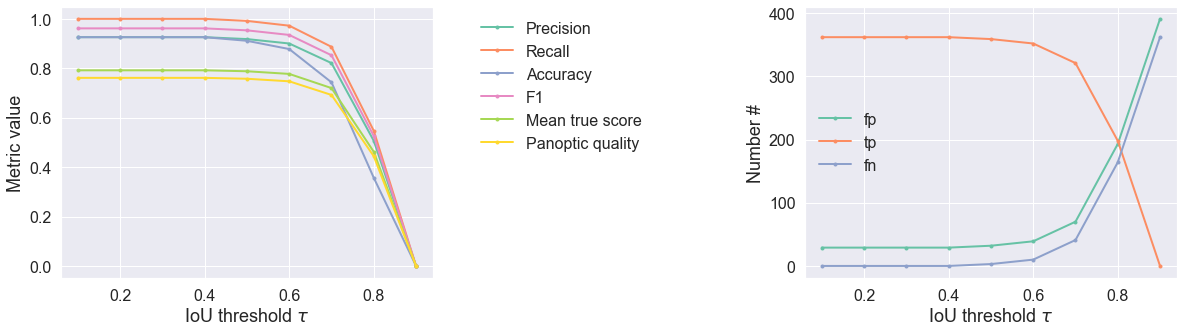

In [28]:
plot_matching_dataset_results(metrics2, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw", "exp10_multithres_plots.png"))

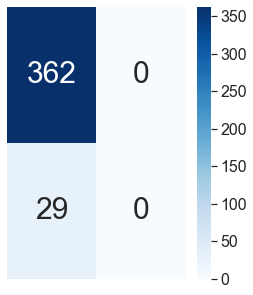

In [29]:
plot_confusion_matrix(metrics2, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw", "exp10_cm.png"))

### Exp11

In [31]:
metrics3 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions3).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|█████████▎                                                                          | 1/9 [00:38<05:05, 38.21s/it]

 22%|██████████████████▋                                                                 | 2/9 [01:15<04:25, 37.87s/it]

 33%|████████████████████████████                                                        | 3/9 [01:52<03:44, 37.41s/it]

 44%|█████████████████████████████████████▎                                              | 4/9 [02:29<03:05, 37.02s/it]

 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:05<02:27, 36.97s/it]

 67%|████████████████████████████████████████████████████████                            | 6/9 [03:43<01:51, 37.12s/it]

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [04:20<01:14, 37.11s/it]

 89%|█████████████████████████

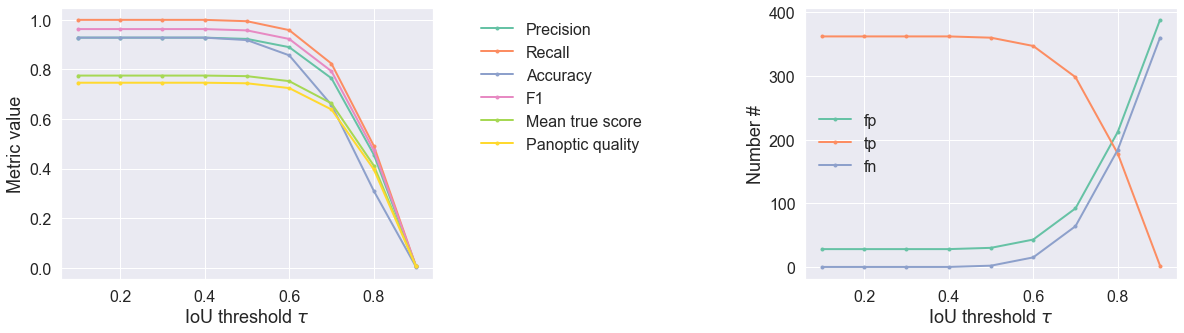

In [32]:
plot_matching_dataset_results(metrics3, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw", "exp11_multithres_plots.png"))

In [33]:
metrics3[taus.index(0.3)]

DatasetMatching(criterion='iou', thresh=0.3, fp=28, tp=362, fn=0, precision=0.9282051282051282, recall=1.0, accuracy=0.9282051282051282, f1=0.9627659574468085, n_true=362, n_pred=390, mean_true_score=0.7750887238518309, mean_matched_score=0.7750887238518309, panoptic_quality=0.746229037325433, by_image=False)

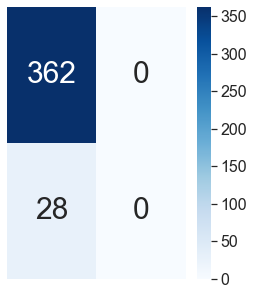

In [34]:
plot_confusion_matrix(metrics3, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw", "exp11_cm.png"))

## Plot all in one

In [35]:
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics1[taus.index(t)]._asdict()[m] for t in taus]
dfs=pd.DataFrame.from_dict(metric, orient='index')

In [36]:
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics2[taus.index(t)]._asdict()[m] for t in taus]
dfs2=pd.DataFrame.from_dict(metric, orient='index')

In [37]:
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics3[taus.index(t)]._asdict()[m] for t in taus]
dfs3=pd.DataFrame.from_dict(metric, orient='index')

In [38]:
alldf=pd.concat([dfs.T, dfs2.T, dfs3.T])
alldf =alldf.reset_index()

In [64]:
alldf.describe()

,level_0,index,fn,fp,precision,recall,accuracy,f1,mean_true_score,mean_matched_score,panoptic_quality
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,4.000000,0.500000,73.370370,106.370370,0.731257,0.797319,0.698965,0.762813,0.620586,0.729050,0.593852
std,2.631174,0.263117,123.228102,123.878088,0.312770,0.340409,0.328442,0.325920,0.260615,0.213344,0.249941
min,0.000000,0.100000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.300000,0.000000,29.000000,0.712497,0.780387,0.595729,0.744841,0.619575,0.752625,0.591436
50%,4.000000,0.500000,3.000000,43.000000,0.893564,0.991713,0.886700,0.939948,0.734264,0.781203,0.694004
75%,6.000000,0.700000,79.500000,114.500000,0.925831,1.000000,0.925831,0.961487,0.775089,0.796876,0.746229
max,8.000000,0.900000,362.000000,404.000000,0.928205,1.000000,0.928205,0.962766,0.791743,0.902440,0.761251


  0%|                                                                                            | 0/9 [45:07<?, ?it/s]


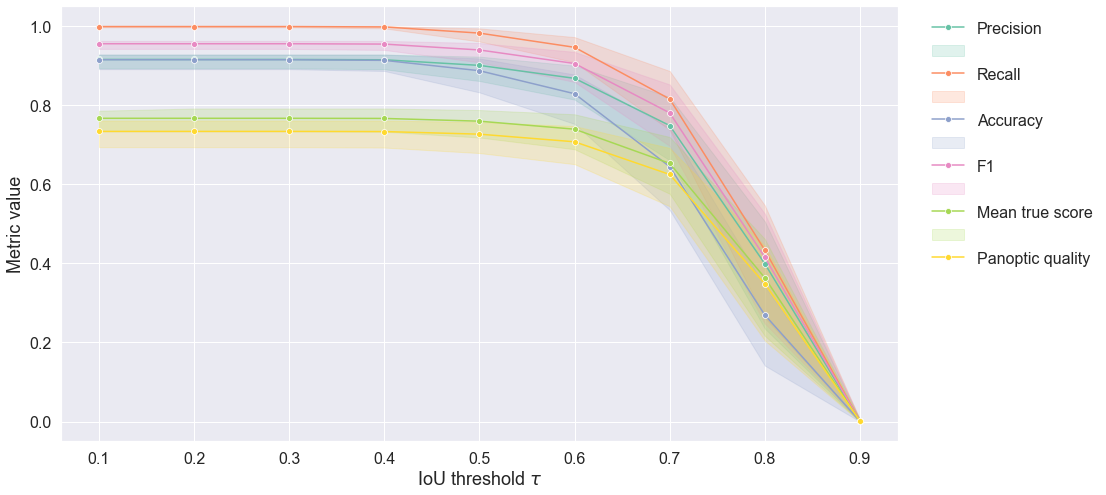

In [42]:
labels = ('Precision', "", 'Recall', "", 'Accuracy', "",'F1', "",'Mean true score', "",'Panoptic quality')

fig, (ax) = plt.subplots(1,1, figsize=(15,8))

sns.lineplot(x="index", y="precision", data=alldf, markers=True, marker='o', ax=ax,legend="auto")
sns.lineplot(x="index", y="recall", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="accuracy", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="f1", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="mean_true_score", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="panoptic_quality", data=alldf, markers=True, marker='o', ax=ax)

ax.set_xlabel(r'IoU threshold $\tau$')
ax.set_ylabel('Metric value')
ax.legend(labels, loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1))

plt.savefig(os.path.join(module_path, "reports", "figures", "stardist", "trained_on_raw", "mean_multithres_plot.png"))

## Boundary based metrics

In [122]:
surf_overlap_of_gt_surf_w_pred_surf = np.array([d[0] for d in surf_overlap_all])
surf_overlap_of_pred_surf_w_gt_surf = np.array([d[1] for d in surf_overlap_all if not math.isnan(d[1])])  # remove NaNs from the list

In [124]:
surf_overlap_of_gt_surf_w_pred_surf_mean = np.mean(surf_overlap_of_gt_surf_w_pred_surf)
print(f"Surface overlap fraction of the GT surfaces with the predicted surfaces: {surf_overlap_of_gt_surf_w_pred_surf_mean}")

ssurf_overlap_of_pred_surf_w_gt_surf_mean = np.mean(surf_overlap_of_pred_surf_w_gt_surf)
print(f"Surface overlap fraction of the predicted surfaces with the GT surfaces: {ssurf_overlap_of_pred_surf_w_gt_surf_mean}")

Surface overlap fraction of the GT surfaces with the predicted surfaces: 0.14716423331020015
Surface overlap fraction of the predicted surfaces with the GT surfaces: 0.1669069177993948


### Exp01

In [44]:
distance_metrics_1 = get_boundary_based_metrics_per_object(predictions1, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [05:30<00:00,  9.43s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [47]:
pd.set_option('display.max_rows', distance_metrics_1.shape[0]+1)
res_df_wo_nans= distance_metrics_1.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final = res_df_wo_nans.reset_index(drop=True)
final

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.470487,0.422174,1.405459,0.670104,0.712242,0.690246,0.867082
1,0.505223,0.450535,1.527895,0.642349,0.712744,0.675731,0.859728
2,0.396548,0.359987,1.160519,0.713886,0.760048,0.736064,0.887530
3,0.558201,0.518027,1.604336,0.553830,0.638640,0.593053,0.836755
4,0.387403,0.323403,1.038000,0.737909,0.809146,0.771895,0.892349
5,0.392398,0.331795,1.107740,0.723318,0.803245,0.760955,0.893050
6,0.340437,0.286984,0.931634,0.759393,0.838868,0.797018,0.907567
7,0.237092,0.222703,0.623760,0.915966,0.942433,0.928859,0.933076
8,0.370201,0.295133,1.094148,0.765997,0.852832,0.806854,0.899551
9,0.389189,0.317833,1.066444,0.728022,0.820455,0.771980,0.896639


In [48]:
final.to_csv(r"metrics/exp01_distance_metrics_df.csv")

### Exp10

In [49]:
distance_metrics_2 = get_boundary_based_metrics_per_object(predictions2, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [05:06<00:00,  8.77s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [50]:
pd.set_option('display.max_rows', distance_metrics_2.shape[0]+1)
res_df_wo_nans2= distance_metrics_2.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final2 = res_df_wo_nans2.reset_index(drop=True)
final2

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.304131,0.217678,1.038000,0.841098,0.931403,0.882997,0.916693
1,0.350803,0.251773,1.211000,0.789271,0.893918,0.837497,0.910208
2,0.251864,0.217598,0.647307,0.904074,0.961575,0.931023,0.928410
3,0.242368,0.225800,0.692000,0.898355,0.938826,0.917821,0.927752
4,0.359393,0.233327,1.223295,0.789201,0.922398,0.849140,0.908421
5,0.297850,0.212990,1.008755,0.833091,0.933510,0.879328,0.926639
6,0.229216,0.193419,0.713297,0.909694,0.963936,0.935159,0.937154
7,0.182894,0.183814,0.519000,0.962301,0.974882,0.968459,0.946957
8,0.390244,0.250398,1.351173,0.782160,0.917766,0.842634,0.904133
9,0.394325,0.269058,1.405459,0.770096,0.875299,0.817859,0.906383


In [51]:
final2.to_csv(r"metrics/exp10_distance_metrics_df.csv")

### Exp11

In [52]:
distance_metrics_3 = get_boundary_based_metrics_per_object(predictions3, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels
distance_metrics_3

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [05:02<00:00,  8.63s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.424167,0.249840,1.730000,0.777267,0.899127,0.832261,0.899049
1,0.357457,0.265120,1.160519,0.772908,0.872852,0.818499,0.906777
2,0.247887,0.197689,0.692000,0.890581,0.966809,0.925751,0.930826
3,0.249974,0.213328,0.773680,0.864262,0.918907,0.889800,0.928409
4,0.408950,0.242868,1.604336,0.778830,0.906755,0.835986,0.904389
5,0.358182,0.267405,1.160519,0.796743,0.887368,0.838500,0.910816
6,0.306978,0.243788,0.947560,0.814938,0.899937,0.854039,0.920247
7,0.186371,0.167041,0.519000,0.953426,0.981570,0.966835,0.948199
8,0.341890,0.227777,1.107740,0.796224,0.914612,0.849168,0.913061
9,0.385971,0.267845,1.271285,0.760323,0.871801,0.810503,0.907825


In [54]:
pd.set_option('display.max_rows', distance_metrics_3.shape[0]+1)
res_df_wo_nans3= distance_metrics_3.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final3 = res_df_wo_nans3.reset_index(drop=True)
final3

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.424167,0.249840,1.730000,0.777267,0.899127,0.832261,0.899049
1,0.357457,0.265120,1.160519,0.772908,0.872852,0.818499,0.906777
2,0.247887,0.197689,0.692000,0.890581,0.966809,0.925751,0.930826
3,0.249974,0.213328,0.773680,0.864262,0.918907,0.889800,0.928409
4,0.408950,0.242868,1.604336,0.778830,0.906755,0.835986,0.904389
5,0.358182,0.267405,1.160519,0.796743,0.887368,0.838500,0.910816
6,0.306978,0.243788,0.947560,0.814938,0.899937,0.854039,0.920247
7,0.186371,0.167041,0.519000,0.953426,0.981570,0.966835,0.948199
8,0.341890,0.227777,1.107740,0.796224,0.914612,0.849168,0.913061
9,0.385971,0.267845,1.271285,0.760323,0.871801,0.810503,0.907825


In [55]:
final3.to_csv(r"metrics/exp11_distance_metrics_df.csv")

### Get the means

In [58]:
df = pd.concat([final, final2, final3], axis=0)
df

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.470487,0.422174,1.405459,0.670104,0.712242,0.690246,0.867082
1,0.505223,0.450535,1.527895,0.642349,0.712744,0.675731,0.859728
2,0.396548,0.359987,1.160519,0.713886,0.760048,0.736064,0.887530
3,0.558201,0.518027,1.604336,0.553830,0.638640,0.593053,0.836755
4,0.387403,0.323403,1.038000,0.737909,0.809146,0.771895,0.892349
...,...,...,...,...,...,...,...
357,1.354781,0.342057,5.538702,0.512343,0.806105,0.621440,0.775890
358,0.553255,0.391461,1.839015,0.624864,0.740097,0.676060,0.874042
359,0.449979,0.365057,1.121168,0.668716,0.777173,0.717773,0.886897
360,0.630032,0.500831,1.557000,0.505759,0.606751,0.550424,0.828949


In [59]:
df.describe()

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
count,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000
mean,0.651467,0.382025,2.203839,0.654744,0.775696,0.707351,0.865618
std,0.441779,0.133167,1.639532,0.138463,0.107620,0.125193,0.060866
min,0.180637,0.167041,0.519000,0.184543,0.339191,0.237667,0.559008
25%,0.378926,0.290511,1.107740,0.552462,0.708914,0.618059,0.842199
50%,0.523420,0.361376,1.641222,0.665131,0.786313,0.718206,0.880524
75%,0.748220,0.440316,2.646391,0.765834,0.860220,0.806612,0.908156
max,3.425603,1.667143,11.998270,0.962301,0.981570,0.968459,0.949238


### Combine with confusion matrix based metrics and save

In [60]:
metrics_combined = {
    'Mean distance from the GT to predicted surface in microns': final3["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": final3["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": final3["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": final3["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": final3["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": final3["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": final3["DSCvol"].mean(),
}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"):
    metrics_combined[m] = metrics2[taus.index(0.3)]._asdict()[m]
metrics_combined

{'Mean distance from the GT to predicted surface in microns': 0.6331740284921306,
 'Mean distance from predicted to the GT surface in microns': 0.3619065980319283,
 'Mean Hausdorff95 distance': 2.1612893976404792,
 'Mean surface overlap fraction of GT surfaces with predicted surfaces': 0.6601095826736799,
 'Mean surface overlap fraction of the predicted surfaces with the GT surfaces': 0.791348898016274,
 'Mean surface DSC': 0.716445770273852,
 'Mean volume DSC over matched objects': 0.87070383284012,
 'tp': 362,
 'fn': 0,
 'fp': 29,
 'precision': 0.9258312020460358,
 'recall': 1.0,
 'accuracy': 0.9258312020460358,
 'f1': 0.9614873837981408,
 'mean_true_score': 0.7917432053971686,
 'mean_matched_score': 0.7917432053971686,
 'panoptic_quality': 0.7612511031972776}

In [62]:
import json

with open("metrics/exp11_best_metrics.json", "w") as f:
    json.dump(metrics_combined, f) 